## 🧠🖼️ Modelo de Detección de Deepfakes
Entrenamiento para un modelo de Inteligencia Artificial que se enfoca en detectar imagenes falsas que hayan sido editadas o generadas por IA utilizando la tecnica conocida como Deep Learning.

El modelo esta realizado en un notebook de Python y pensado para poder guardarse en un directorio correspondiente una vez terminado su entrenamiento.

#### 📌Update:
Mejorado con MobileNetV2 y Xception + Preprocesamiento MTCNN + Data Augmentation + Metrics Avanzadas

### Comprobamos el uso de la GPU
Para el entrenamiento de este modelo se recomienda utilizar una unidad de procesamiento grafico (GPU) para agilizar el proceso de entrenamiento. En caso de no poseer una, puede utilizar la potencia de su CPU para poder correr el entrenamiento. Sin embargo, le tomara mas tiempo hacerlo con ese enfoque.

In [1]:
# Testeamos que esta usando la GPU
import tensorflow as tf
gpu_available = tf.config.list_physical_devices('GPU')
if not gpu_available:
    print("GPU no disponible. Se usará la CPU.")
else:
    print("GPU disponible. Se usará la GPU:", gpu_available[0].name)
    print("---------------------------------")
    print("Información de la GPU:")
    # Revisamos información de la GPU
    !nvidia-smi

GPU disponible. Se usará la GPU: /physical_device:GPU:0
---------------------------------
Información de la GPU:
Wed Aug  6 13:41:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.57                 Driver Version: 576.57         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:07:00.0  On |                  N/A |
|  0%   49C    P0             40W /  175W |    1076MiB /   8192MiB |     11%      Default |
|                          

### 📘 Celda 1 - Importación de librerías y configuración inicial
En esta celda importamos las librerías esenciales, configuramos
parámetros globales (como tamaños de imagen y batch size)
y definimos las rutas de los datasets.

In [6]:
# Librerías necesarias
# !pip install mtcnn

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight
from mtcnn.mtcnn import MTCNN
import cv2
from tqdm import tqdm
import gc

# === Parámetros ===
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 30

# === Rutas de los datasets ===
train_dir = "../data/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
val_dir = "../data/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid"
test_dir = "../data/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"

### 📘 Celda 2 - Función de detección y recorte facial con MTCNN
Definimos funciones para detectar y recortar rostros usando MTCNN.
Esto ayuda a mejorar la precisión enfocándonos solo en la cara.
También definimos una función que recorre el dataset y guarda las imágenes recortadas.


In [2]:
# --- Detección y recorte facial usando MTCNN ---
def crop_face(image, detector):
    faces = detector.detect_faces(image)
    if faces:
        x, y, w, h = faces[0]['box']
        x, y = max(0, x), max(0, y)
        return image[y:y+h, x:x+w]
    return image  # Si no detecta cara, devuelve la imagen original


# --- Preprocesamiento y guardado de imágenes ---
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    detector = MTCNN()  # ✅ Crear detector una sola vez

    for root, _, files in os.walk(input_dir):
        if not files:
            continue

        rel_path = os.path.relpath(root, input_dir)
        save_dir = os.path.join(output_dir, rel_path)
        os.makedirs(save_dir, exist_ok=True)

        # Detectar si ya existen imágenes preprocesadas
        already_done = [f for f in files if os.path.exists(os.path.join(save_dir, f))]
        if len(already_done) == len(files):
            print(f"✅ Todas las imágenes ya están preprocesadas en {rel_path}, saltando...")
            continue
        elif already_done:
            print(f"🔄 Reanudando desde la imagen: {already_done[-1]} en {rel_path} - ({len(already_done)}/{len(files)} hechas)...")

        for idx, f in enumerate(tqdm(files, desc=f"Procesando {root}")):
            img_path = os.path.join(root, f)
            save_path = os.path.join(save_dir, f)

            # Saltar si ya existe
            if os.path.exists(save_path):
                continue

            try:
                img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
                face = crop_face(img, detector)
                face = cv2.resize(face, IMG_SIZE)
                cv2.imwrite(save_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"⚠️ Error procesando {img_path}: {e}")

            # ✅ Liberar memoria cada 50 imágenes
            if idx % 50 == 0:
                del img, face
                gc.collect()


# --- Ejecución ---
print("Preprocesando conjunto de entrenamiento...")
preprocess_and_save(train_dir, "./preprocessed/train_faces")

print("Preprocesando conjunto de validación...")
preprocess_and_save(val_dir, "./preprocessed/valid_faces")

print("Preprocesando conjunto de prueba...")
preprocess_and_save(test_dir, "./preprocessed/test_faces")

Preprocesando conjunto de entrenamiento...
✅ Todas las imágenes ya están preprocesadas en fake, saltando...
✅ Todas las imágenes ya están preprocesadas en real, saltando...
Preprocesando conjunto de validación...
✅ Todas las imágenes ya están preprocesadas en fake, saltando...
✅ Todas las imágenes ya están preprocesadas en real, saltando...
Preprocesando conjunto de prueba...
✅ Todas las imágenes ya están preprocesadas en fake, saltando...
✅ Todas las imágenes ya están preprocesadas en real, saltando...


### 📘 Celda 3 - Previsualización
Utilizando PyPlot previsualizamos algunas de las imagenes que fueron preprocesadas para entrenar el modelo, es decir, en la carpeta `train_faces`. 

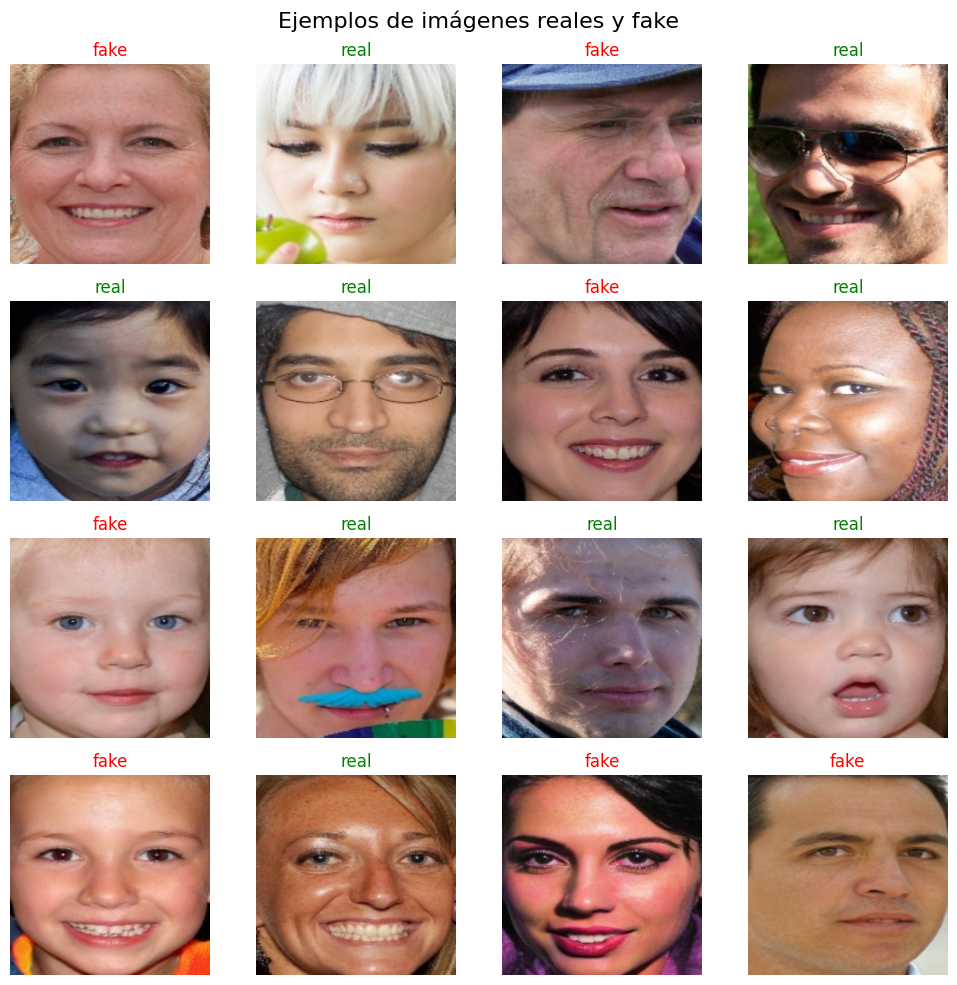

In [5]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

folder_path = "./preprocessed/train_faces/"

# Buscar imágenes en subcarpetas real y fake
image_files = []
for label in ["real", "fake"]:
    path = os.path.join(folder_path, label)
    files = [(os.path.join(path, f), label) for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files.extend(files)

# Elegir 9 imágenes aleatorias
sample_files = random.sample(image_files, 16)

# Mostrar imágenes con label
plt.figure(figsize=(10, 10))
# Centro las imágenes en una cuadrícula de 3x3
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.suptitle("Ejemplos de imágenes reales y fake", fontsize=16)
for i, (file_path, label) in enumerate(sample_files):
    img = Image.open(file_path)
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(label, fontsize=12, color="green" if label == "real" else "red")  # color según clase

plt.tight_layout()
plt.show()

### 📘 Celda 4 - Data Augmentation y Generadores
Creamos generadores de imágenes con Data Augmentation para el set de entrenamiento,
y solo reescalado para validación y test.

In [7]:
# === Data Augmentation ===
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# === Generadores de imágenes ===
train_generator = train_datagen.flow_from_directory('./preprocessed/train_faces',
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')
validation_generator = val_datagen.flow_from_directory('./preprocessed/valid_faces',
                                                       target_size=IMG_SIZE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### 📘 Celda 5 - Cálculo de pesos de clase
Calculamos pesos para manejar desbalance entre clases (si existe),
lo que ayuda a mejorar la precisión cuando hay más ejemplos de una clase.


In [8]:
# --- Pesos de clase ---
y_train = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Pesos de clase:", class_weights_dict)

Pesos de clase: {0: 1.0, 1: 1.0}


### 📘 Celda 6 - Modelo 1: MobileNetV2
Creamos un modelo base usando MobileNetV2 preentrenada en ImageNet.
Congelamos su base y agregamos capas densas para la clasificación binaria.

In [12]:
# === Modelo 1: MobileNetV2 ===

# Cargamos MobileNetV2 preentrenada en ImageNet
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_mobilenet.trainable = False

# Agregamos capas adicionales para la clasificación binaria
mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compilamos el modelo
mobilenet_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy', AUC(name='auc')])

# Agregamos callbacks para el entrenamiento
callbacks = [EarlyStopping(patience=7, restore_best_weights=True),
             ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
             ModelCheckpoint('mobilenet_model.h5', save_best_only=True)]

# Entrenamos el modelo
history_mobilenet = mobilenet_model.fit(train_generator,
                                        validation_data=validation_generator,
                                        epochs=EPOCHS,
                                        class_weight=class_weights_dict,
                                        callbacks=callbacks)

Epoch 1/30
782/782 [==============================] - 2016s 3s/step - loss: 0.6670 - accuracy: 0.6119 - auc: 0.6568 - val_loss: 0.5859 - val_accuracy: 0.6894 - val_auc: 0.7595 - lr: 1.0000e-04
Epoch 2/30
782/782 [==============================] - 744s 951ms/step - loss: 0.6071 - accuracy: 0.6736 - auc: 0.7366 - val_loss: 0.5649 - val_accuracy: 0.7089 - val_auc: 0.7830 - lr: 1.0000e-04
Epoch 3/30
782/782 [==============================] - 740s 946ms/step - loss: 0.5857 - accuracy: 0.6913 - auc: 0.7587 - val_loss: 0.5524 - val_accuracy: 0.7200 - val_auc: 0.7951 - lr: 1.0000e-04
Epoch 4/30
782/782 [==============================] - 751s 961ms/step - loss: 0.5725 - accuracy: 0.7019 - auc: 0.7725 - val_loss: 0.5443 - val_accuracy: 0.7264 - val_auc: 0.8037 - lr: 1.0000e-04
Epoch 5/30
782/782 [==============================] - 958s 1s/step - loss: 0.5653 - accuracy: 0.7102 - auc: 0.7807 - val_loss: 0.5387 - val_accuracy: 0.7307 - val_auc: 0.8094 - lr: 1.0000e-04
Epoch 6/30
782/782 [==========

### 📘 Celda 7 - Modelo 2: Xception
Creamos un segundo modelo usando Xception para comparar el rendimiento.

In [9]:
# === Modelo 2: Xception ===

# Cargamos Xception preentrenada en ImageNet
base_xception = Xception(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_xception.trainable = False

# Agregamos capas adicionales para la clasificación binaria
xception_model = models.Sequential([
    base_xception,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compilamos el modelo
xception_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy', AUC(name='auc')])

# Agregamos callbacks para el entrenamiento
callbacks_x = [EarlyStopping(patience=7, restore_best_weights=True),
               ReduceLROnPlateau(patience=3, factor=0.2, verbose=1),
               ModelCheckpoint('xception_model.h5', save_best_only=True)]

# Entrenamos el modelo
history_xception = xception_model.fit(train_generator,
                                      validation_data=validation_generator,
                                      epochs=EPOCHS,
                                      class_weight=class_weights_dict,
                                      callbacks=callbacks_x)

83683744/83683744 [==============================] - 4s 0us/step
Epoch 1/30
782/782 [==============================] - 3372s 4s/step - loss: 0.6230 - accuracy: 0.6491 - auc: 0.7085 - val_loss: 0.5928 - val_accuracy: 0.6800 - val_auc: 0.7512 - lr: 1.0000e-04
Epoch 2/30
782/782 [==============================] - 803s 1s/step - loss: 0.5951 - accuracy: 0.6814 - auc: 0.7465 - val_loss: 0.5774 - val_accuracy: 0.6963 - val_auc: 0.7698 - lr: 1.0000e-04
Epoch 3/30
782/782 [==============================] - 789s 1s/step - loss: 0.5824 - accuracy: 0.6920 - auc: 0.7615 - val_loss: 0.5678 - val_accuracy: 0.7064 - val_auc: 0.7795 - lr: 1.0000e-04
Epoch 4/30
782/782 [==============================] - 787s 1s/step - loss: 0.5762 - accuracy: 0.6987 - auc: 0.7688 - val_loss: 0.5610 - val_accuracy: 0.7158 - val_auc: 0.7884 - lr: 1.0000e-04
Epoch 5/30
782/782 [==============================] - 790s 1s/step - loss: 0.5698 - accuracy: 0.7056 - auc: 0.7757 - val_loss: 0.5558 - val_accuracy: 0.7175 - val_auc

### 📘 Celda 8 - Evaluación final de modelos
Evaluamos ambos modelos en el conjunto de test. Imprimimos métricas de pérdida, accuracy y AUC.

In [13]:
# === Evaluación final ===
test_generator = test_datagen.flow_from_directory('./preprocessed/test_faces',
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle=False)

mobile_results = mobilenet_model.evaluate(test_generator)
xception_results = xception_model.evaluate(test_generator)

print("MobileNetV2 Test Results - Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}".format(*mobile_results))
print("Xception Test Results - Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}".format(*xception_results))

Found 20000 images belonging to 2 classes.
157/157 [==============================] - 48s 306ms/step - loss: 0.5190 - accuracy: 0.7466 - auc: 0.8246
MobileNetV2 Test Results - Loss: 0.5158, Accuracy: 0.7497, AUC: 0.8292
Xception Test Results - Loss: 0.5190, Accuracy: 0.7466, AUC: 0.8246


### 📘 Celda 9 - Detección de imagenes utilizando ambos modelos
Definimos funciones para detectar imagenes cargadas por un usuario a traves de un path. Luego comparamos cual fue el que mas aciertos tuvo en comparación con los modelos previamente entrenados.

In [2]:
# Importamos librerias
from tensorflow.keras.models import load_model

# Cargamos los modelos entrenados
mobilenet_model = load_model('mobilenet_model.h5')
xception_model = load_model('xception_model.h5')

# Vemos resumen para confirmar que se han cargado correctamente
mobilenet_model.summary()
xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Model: "sequential"
____________________

Detección con MobileNetV2:
1/1 [==============================] - 0s 23ms/step
Imagen: DB6TPRB359.jpg, Predicción: Fake (Confianza: 0.8111)
Ruta: ./preprocessed/test_faces/fake\DB6TPRB359.jpg
1/1 [==============================] - 0s 22ms/step
Imagen: 51189.jpg, Predicción: Real (Confianza: 0.7611)
Ruta: ./preprocessed/test_faces/real\51189.jpg
1/1 [==============================] - 0s 21ms/step
Imagen: 61241.jpg, Predicción: Real (Confianza: 0.7037)
Ruta: ./preprocessed/test_faces/real\61241.jpg
1/1 [==============================] - 0s 21ms/step
Imagen: EOMSRDGKIB.jpg, Predicción: Fake (Confianza: 0.6485)
Ruta: ./preprocessed/test_faces/fake\EOMSRDGKIB.jpg


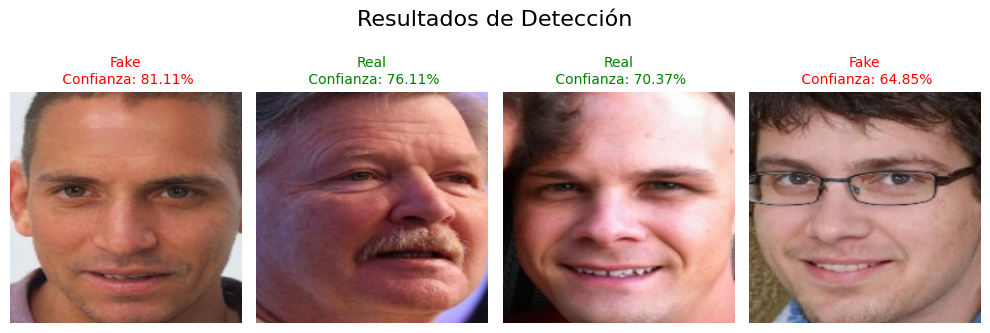


Detección con Xception:
1/1 [==============================] - 0s 33ms/step
Imagen: EHC5APWUOB.jpg, Predicción: Fake (Confianza: 0.8262)
Ruta: ./preprocessed/test_faces/fake\EHC5APWUOB.jpg
1/1 [==============================] - 0s 22ms/step
Imagen: 35236.jpg, Predicción: Real (Confianza: 0.7920)
Ruta: ./preprocessed/test_faces/real\35236.jpg
1/1 [==============================] - 0s 22ms/step
Imagen: A2KI764GCE.jpg, Predicción: Real (Confianza: 0.5794)
Ruta: ./preprocessed/test_faces/fake\A2KI764GCE.jpg
1/1 [==============================] - 0s 21ms/step
Imagen: S53KKNP89X.jpg, Predicción: Fake (Confianza: 0.7819)
Ruta: ./preprocessed/test_faces/fake\S53KKNP89X.jpg


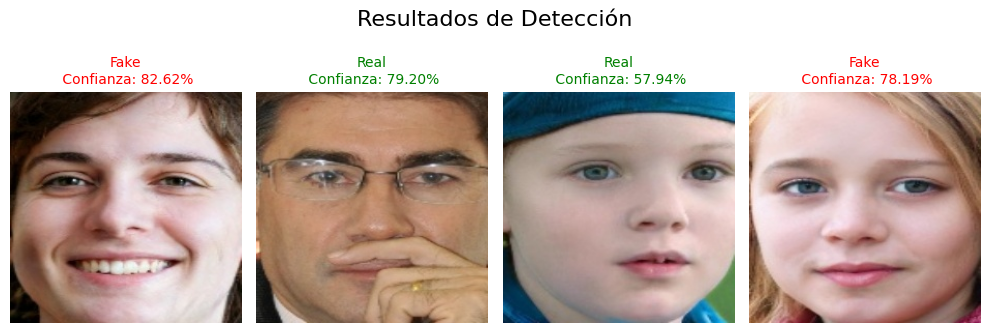

In [23]:
# Importar librerías necesarias para la detección de imágenes
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Definimos el tamaño de imagen para la detección
IMG_SIZE = (224, 224)

# Definimos path donde vamos a elegir las imagenes a detectar
path = "./preprocessed/test_faces/"

# Definimos la función para detectar imágenes
def detect_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = np.expand_dims(img, axis=0) / 255.0  # Normalizamos
    prediction = model.predict(img)
    return prediction[0][0]

# Graficamos las imágenes con sus resultados y su path real
def plot_detections(results, img_paths, confidence_scores):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.suptitle("Resultados de Detección", fontsize=16)
    
    for i, (fname, label) in enumerate(results.items()):
        img_path = img_paths[fname]
        img = Image.open(img_path)
        plt.subplot(1, len(results), i+1)
        plt.imshow(img)
        plt.axis("off")
        # Mostrar label y path en líneas separadas y con tamaño adecuado
        plt.title(f"{label.capitalize()}\n Confianza: {confidence_scores[fname]*100:.2f}%", fontsize=10, color="green" if label == "real" else "red")

    plt.tight_layout(rect=[0, 0, 1, 1.6])
    plt.show()

# Definimos la función para detectar imágenes en un directorio
def detect_images_in_directory(model, directory):
    results = {}
    img_paths = {}
    confidence_scores = {}

    # Reunir todas las imágenes en una lista
    all_images = []
    for root, _, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, f))

    # Elegir 4 imágenes al azar (o menos si hay menos de 4 disponibles)
    selected_images = random.sample(all_images, min(4, len(all_images)))

    # Procesar las imágenes seleccionadas
    for img_path in selected_images:
        f = os.path.basename(img_path)
        prediction = detect_image(model, img_path)
        label = "real" if prediction > 0.5 else "fake"
        confidence = prediction if label == "real" else 1 - prediction
        confidence_scores[f] = confidence
        results[f] = label
        img_paths[f] = img_path
        print(f"Imagen: {f}, Predicción: {label.capitalize()} (Confianza: {confidence:.4f})")
        print(f"Ruta: {img_path}")

    # Graficar solo las imágenes seleccionadas
    plot_detections(results, img_paths, confidence_scores)

    return results


# Ejecutamos la detección con ambos modelos
print("Detección con MobileNetV2:")
mobilenet_detections = detect_images_in_directory(mobilenet_model, path)
print("\nDetección con Xception:")
xception_detections = detect_images_in_directory(xception_model, path)